In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import sqlite3 
conn = sqlite3.connect('im.db')
imdb_basics_df = pd.read_sql("""
SELECT * FROM movie_basics
;""",conn)
imdb_basics_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [24]:
list(bom_df.title.values)

['Toy Story 3',
 'Alice in Wonderland (2010)',
 'Harry Potter and the Deathly Hallows Part 1',
 'Inception',
 'Shrek Forever After',
 'The Twilight Saga: Eclipse',
 'Iron Man 2',
 'Tangled',
 'Despicable Me',
 'How to Train Your Dragon',
 'Clash of the Titans (2010)',
 'The Chronicles of Narnia: The Voyage of the Dawn Treader',
 "The King's Speech",
 'Tron Legacy',
 'The Karate Kid',
 'Prince of Persia: The Sands of Time',
 'Black Swan',
 'Megamind',
 'Robin Hood',
 'The Last Airbender',
 'Little Fockers',
 'Resident Evil: Afterlife',
 'Shutter Island',
 'Salt',
 'Sex and the City 2',
 'The Tourist',
 'The Expendables',
 'Grown Ups',
 'Knight & Day',
 'True Grit',
 "Gulliver's Travels",
 'Percy Jackson & The Olympians: The Lightning Thief',
 'The Social Network',
 "Valentine's Day",
 "The Sorcerer's Apprentice",
 'Due Date',
 'Eat Pray Love',
 'Yogi Bear',
 'Red',
 'Paranormal Activity 2',
 'The A-Team',
 'Jackass 3-D',
 'The Other Guys',
 'Unstoppable',
 'Step Up 3-D',
 'The Book of E

In [26]:
key_titles = []
bom_list = list(bom_df.title.values)
for i,v in enumerate(list(imdb_basics_df.primary_title.values)):
    if v in bom_list:
        key_titles.append(v)
    elif imdb_basics_df.primary_title.values[i] in bom_list:
        key_titles.append(imdb_basics_df.primary_title.values[i])
    else: key_titles.append(np.NaN)
len(list(set(key_titles)))

2606

In [27]:
imdb_basics_df['key_title'] = key_titles

In [43]:
imdb_basics_df.loc[imdb_basics_df.key_title.notna()]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,key_title
38,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",Wazir
48,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",On the Road
54,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",The Secret Life of Walter Mitty
58,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",A Walk Among the Tombstones
60,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",Jurassic World
...,...,...,...,...,...,...,...
133797,tt8404272,How Long Will I Love U,Chao shi kong tong ju,2018,101.0,Romance,How Long Will I Love U
134045,tt8427036,Helicopter Eela,Helicopter Eela,2018,135.0,Drama,Helicopter Eela
137854,tt8851262,Spring Fever,Spring Fever,2019,NaN,"Comedy,Horror",Spring Fever
140171,tt9078374,Last Letter,"Ni hao, Zhihua",2018,114.0,"Drama,Romance",Last Letter


In [42]:

imdb_basics_df.drop_duplicates(subset = 'key_title', inplace = True)

In [44]:
tmdb_df = pd.read_csv('tmdb.movies.csv')
tmdb_df

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [45]:
bom_df = pd.read_csv('bom.movie_gross.csv')

In [46]:
bom_df.foreign_gross

0       652000000
1       691300000
2       664300000
3       535700000
4       513900000
          ...    
3382          NaN
3383          NaN
3384          NaN
3385          NaN
3386          NaN
Name: foreign_gross, Length: 3387, dtype: object

In [47]:

bom_df.foreign_gross.str.replace(',', '').astype('float64')

0       652000000.0
1       691300000.0
2       664300000.0
3       535700000.0
4       513900000.0
           ...     
3382            NaN
3383            NaN
3384            NaN
3385            NaN
3386            NaN
Name: foreign_gross, Length: 3387, dtype: float64

In [48]:
budg_df = pd.read_csv('tn.movie_budgets.csv')
budg_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [49]:
info_df = pd.read_csv('rt.movie_info.tsv',delimiter='\t')
info_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [50]:
review_df = pd.read_csv('rt.reviews.tsv',delimiter='\t',encoding='windows-1252')
review_df

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [57]:
merged_df = imdb_basics_df.merge(right=bom_df,how='left',left_on='key_title',right_on='title')
merged_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1523 entries, 2 to 2606
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         1523 non-null   object 
 1   primary_title    1523 non-null   object 
 2   original_title   1523 non-null   object 
 3   start_year       1523 non-null   int64  
 4   runtime_minutes  1523 non-null   float64
 5   genres           1523 non-null   object 
 6   key_title        1523 non-null   object 
 7   title            1523 non-null   object 
 8   studio           1523 non-null   object 
 9   domestic_gross   1523 non-null   float64
 10  foreign_gross    1523 non-null   object 
 11  year             1523 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 154.7+ KB


In [60]:
merged_df = imdb_basics_df.merge(right=budg_df,how='left',left_on='key_title',right_on='movie')

In [62]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 0 to 2614
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2615 non-null   object 
 1   primary_title      2615 non-null   object 
 2   original_title     2615 non-null   object 
 3   start_year         2615 non-null   int64  
 4   runtime_minutes    2576 non-null   float64
 5   genres             2604 non-null   object 
 6   key_title          2614 non-null   object 
 7   id                 1167 non-null   float64
 8   release_date       1167 non-null   object 
 9   movie              1167 non-null   object 
 10  production_budget  1167 non-null   object 
 11  domestic_gross     1167 non-null   object 
 12  worldwide_gross    1167 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 286.0+ KB


In [77]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2615 entries, 0 to 2614
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2615 non-null   object 
 1   primary_title      2615 non-null   object 
 2   original_title     2615 non-null   object 
 3   start_year         2615 non-null   int64  
 4   runtime_minutes    2576 non-null   float64
 5   genres             2604 non-null   object 
 6   key_title          2614 non-null   object 
 7   id                 1167 non-null   float64
 8   release_date       1167 non-null   object 
 9   movie              1167 non-null   object 
 10  production_budget  1167 non-null   object 
 11  domestic_gross     1167 non-null   object 
 12  worldwide_gross    1167 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 286.0+ KB


C:\Users\kapta\AppData\Local\Temp\ipykernel_16108\2621666496.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x=merged_df.production_budget.str.replace("$","").str.replace(',','').astype('float64')
C:\Users\kapta\AppData\Local\Temp\ipykernel_16108\2621666496.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  y=(merged_df.worldwide_gross.str.replace("$","").str.replace(',','').astype('float64')-x)/x


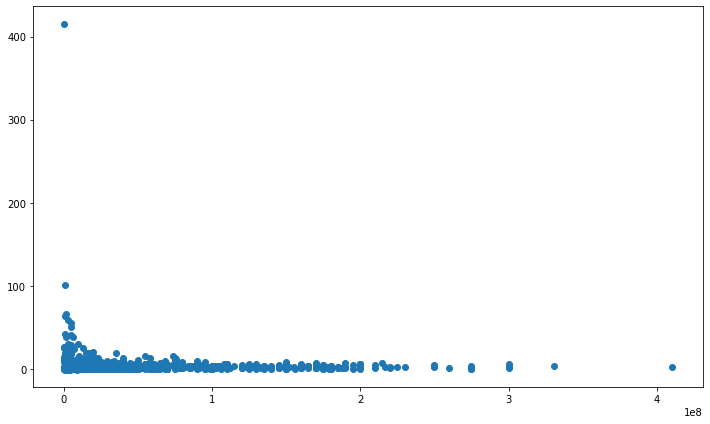

In [91]:
x=merged_df.production_budget.str.replace("$","").str.replace(',','').astype('float64')
y=(merged_df.worldwide_gross.str.replace("$","").str.replace(',','').astype('float64')-x)/x
fig,ax = plt.subplots(figsize=(12,7))
ax.scatter(x,y)

In [89]:
sorted((x/y))

[nan,
 nan,
 2363579.725425355,
 4405815.551392248,
 6395545.837160474,
 6884997.590250843,
 12623053.23416873,
 16650556.020342465,
 18597423.636912167,
 23191692.10842265,
 28034608.144868232,
 30451137.548820764,
 37422365.36177181,
 44080420.80731494,
 45854116.88550153,
 48031235.872750424,
 52891523.457649715,
 54852440.94283892,
 67108314.5376366,
 nan,
 68268562.72575632,
 93990493.8246621,
 nan,
 115264490.0593244,
 267435844.5721221,
 nan,
 nan,
 nan,
 nan,
 nan,
 9392817.470279811,
 15456584.90228371,
 nan,
 15681405.757312264,
 27401151.387612943,
 nan,
 nan,
 nan,
 nan,
 nan,
 412460.63372596557,
 21463440.40931114,
 23658306.184731152,
 nan,
 2681562.298306711,
 7537632.4137393655,
 7543560.947296693,
 8076160.128288189,
 8190866.557641986,
 9648798.799930649,
 13260935.257296124,
 14632061.365507513,
 16561566.962721236,
 17557990.75132837,
 18821796.70382248,
 20459924.540175185,
 31138649.935408276,
 31802485.017386883,
 32158289.96363621,
 50074932.35132577,
 53043658